In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import pandas_to_pybeh as pb
from cmlreaders import CMLReader, get_data_index
from plotting import *

In [2]:
# 1. If I want all FR1 and pyFR subjects
df = get_data_index("r1")
FR1_subs=df[df['experiment']=='FR1']['subject'].unique() # all FR1 subjects
exp = 'FR1' 

FR_subs=[]
FR_subs = list(FR1_subs)
print('Total number of FR subjects: ',len(FR_subs))
catfr_subs = np.load('catfrsubs.npy', allow_pickle=True)
all_subs = pd.concat([pd.Series(FR1_subs), pd.Series(catfr_subs)])
all_fr_subs = all_subs.apply(lambda x: x[2:5]).astype(int)
pd.concat([all_fr_subs]).nunique()
# all_subs.nunique()

Total number of FR subjects:  281


368

In [3]:
evs = []
from tqdm.notebook import tqdm
for i, sub in enumerate(tqdm(FR_subs)):

#     print(sub, str(i/len(both)*100) + "% Done")
    exp = 'FR1'
    df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
    sessions = list(df[(df['subject']==sub) & (df['experiment']==exp)]['session'])
    for sess in sessions:
        reader = CMLReader(sub, exp, sess)
        evs.append(reader.load('events'))
evs = pd.concat(evs)

In [4]:
word_evs = evs[evs.type =='WORD']

zscore = (word_evs.groupby(['subject', 'session', 'list']).recalled.sum().groupby(['subject', 'session']).mean().groupby('subject').mean()).reset_index()
zscore['subject'] = zscore.subject.apply(lambda x: int(x[2:5]))
zscore.set_index('subject',inplace=True)
ages = pd.read_csv('FR1_subject_ages.csv')
ages = ages.dropna(subset=['Age at Implant (calculated)']).set_index('Subject Number')
zscore['age']=ages['Age at Implant (calculated)']
zscore.to_csv('fr1_age.csv')
# zscore['zscore'] = (zscore['recalled'] - mturk_mean)/mturk_std

In [5]:
first_five = word_evs[word_evs.list < 6]

five_zscore = (first_five.groupby(['subject', 'session', 'list']).recalled.mean().groupby(['subject', 'session']).mean().groupby('subject').mean()).reset_index()

mt_fr_ff = np.load('final_fr1_five_stats.npy')
m_fr1_fmean = mt_fr_ff.mean()
m_fr1_fstd = mt_fr_ff.std()
five_zscore['zscore'] = (five_zscore.recalled - m_fr1_fmean )/ m_fr1_fstd
fr_f_mean = five_zscore.zscore.mean()
fr_f_std = five_zscore.zscore.std()
fr_f_n = five_zscore.shape[0]
fr_f_sem = fr_f_std/np.sqrt(fr_f_n)



In [6]:
age_test = zscore.dropna()
r, p = scipy.stats.pearsonr(age_test.recalled, age_test.age)
n = age_test.shape[0]
np.save('FR1vAge.npy', [r, n])

In [7]:
def get_age_group(age):
    if 20 <= age < 30:
        return '20-29'
    elif 30 <= age < 40:
        return '30-39'
    elif 40 <= age <50:
        return '40-49'
    elif 50 <= age < 60:
        return '50-59'
    elif 60 <= age < 70:
        return '60-69'
    else:
        return np.nan

In [8]:
zscore['age_group'] = zscore.age.apply(get_age_group)
zscore.dropna(subset=['age_group'], inplace=True)
zscore

recalled        age age_group
subject                               
1        2.300000  48.105026     40-49
2        4.680000  49.383743     40-49
3        3.958182  39.390382     30-39
6        3.760000  20.553582     20-29
10       2.260000  30.801454     30-39
...           ...        ...       ...
565      2.181818  41.243717     40-49
569      2.440000  22.573929     20-29
571      2.160000  31.283325     30-39
572      3.000000  35.820037     30-39
573      2.000000  41.700948     40-49

[262 rows x 3 columns]

In [9]:
def get_zscore(age_group, score, norms):
    norms = norms[norms.age_group == age_group]
    zscore = (score - norms['mean'].values[0])/norms['std'].values[0]
    return zscore

In [10]:
norms = pd.read_csv('catfr_mturk_norms.csv')
zscore_by_age = zscore.apply(lambda x: get_zscore(x.age_group, x.recalled, norms), axis=1)
zscore_by_age

subject
1     -2.221764
2     -0.835502
3     -1.061704
6     -1.816523
10    -2.008570
         ...   
565   -2.290600
569   -2.608937
571   -2.064327
572   -1.595963
573   -2.396503
Length: 262, dtype: float64

In [14]:
fr1_mean = zscore_by_age.mean()
fr1_std = zscore_by_age.std()
fr1_n = zscore_by_age.count()
fr1_sem = fr1_std/np.sqrt(fr1_n)

262 192.0 111.0 161.0


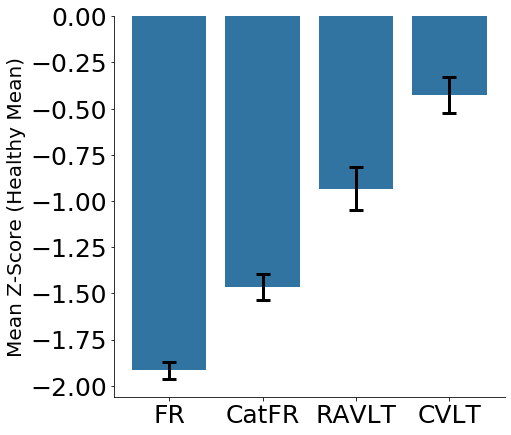

In [16]:
rav_turk= np.load('ravmturkhospitalzscore.npy')
turk_mean = rav_turk[0]
turk_std = rav_turk[1]
turk_n = rav_turk[2]
turk_sem = turk_std/np.sqrt(turk_n)

cat_turk = np.load('cathospitalzscore.npy')
cat_mean = cat_turk[0]
cat_std = cat_turk[1]
cat_n = cat_turk[2]
cat_sem = cat_std/np.sqrt(cat_n)

rav_mean_std = np.load('ravhospitalzscore.npy')
rav_mean = rav_mean_std[0]
rav_std = rav_mean_std[1]
rav_n = rav_mean_std[2]
rav_sem = rav_std/np.sqrt(rav_n)

cvl = np.load('cvlhospitalzscore.npy')
cvl_mean = cvl[0]
cvl_std = cvl[1]
cvl_n = cvl[2]
cvl_sem = cvl_std/np.sqrt(cvl_n)

cat_five = np.load('cat_five_zscore.npy')
cat_fmean = cat_five.mean()
cat_fstd = cat_five.std()
cat_f_n = cat_five.shape[0]
cat_fsem = cat_fstd/np.sqrt(cat_f_n)

print(fr1_n, cat_n, rav_n, cvl_n)
set_axes(fontsize = 25)
# *** WITH First 5 *** #
# sns.barplot(x = ['FR', 'FR First 5', 'CatFR', 'CatFR First 5', 'RAVLT', 'CVLT'],y=[fr1_mean, fr_f_mean, cat_mean, cat_fmean, rav_mean, cvl_mean], palette=['C0', 'C0'])
# plt.errorbar(x=['FR', 'FR First 5', 'CatFR', 'CatFR First 5', 'RAVLT', 'CVLT'], y = [fr1_mean, fr_f_mean, cat_mean, cat_fmean, rav_mean, cvl_mean], yerr = [fr1_sem, fr_f_sem, cat_sem, cat_fsem, rav_sem, cvl_sem], linestyle='', color = 'black', capsize= 7, capthick=3, elinewidth=3)
sns.barplot(x = ['FR', 'CatFR', 'RAVLT', 'CVLT'],y=[fr1_mean, cat_mean, rav_mean, cvl_mean], palette=['C0', 'C0'])
plt.errorbar(x=['FR', 'CatFR', 'RAVLT', 'CVLT'], y = [fr1_mean, cat_mean, rav_mean, cvl_mean], yerr = [fr1_sem, cat_sem, rav_sem, cvl_sem], linestyle='', color = 'black', capsize= 7, capthick=3, elinewidth=3)
plt.ylabel('Mean Z-Score (Healthy Mean)', fontsize=20)
# plt.xticks(fontsize = 20, rotation = 45)
plt.savefig('figures/hosp_vs_healthy.pdf', bbox_inches='tight')
